# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [22]:
import pandas as pd 
import numpy as np
import seaborn as sns
import os
print(os.listdir())
import project_1 as est
%load_ext autoreload
%autoreload 2

['2025-09_Project_1.pdf', 'Assignment_1.ipynb', 'firms.csv', 'project_1.py', 'read (1).ipynb', 'read.ipynb', '__pycache__']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
dat = pd.read_csv('firms.csv')

# Descriptives

In [24]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1973.500000,-7.125472e-09,-1.252834e-08,4.695767e-09
std,127.317437,3.452379,1.310973e+00,1.180122e+00,1.232499e+00
min,1.000000,1968.000000,-3.864950e+00,-3.382780e+00,-3.551540e+00
25%,111.000000,1970.750000,-9.083267e-01,-7.855270e-01,-9.279720e-01
50%,221.000000,1973.500000,-1.180615e-01,-1.137295e-01,-1.029710e-01
75%,331.000000,1976.250000,9.063340e-01,7.930060e-01,8.562296e-01
max,441.000000,1979.000000,4.103687e+00,3.371332e+00,3.913391e+00


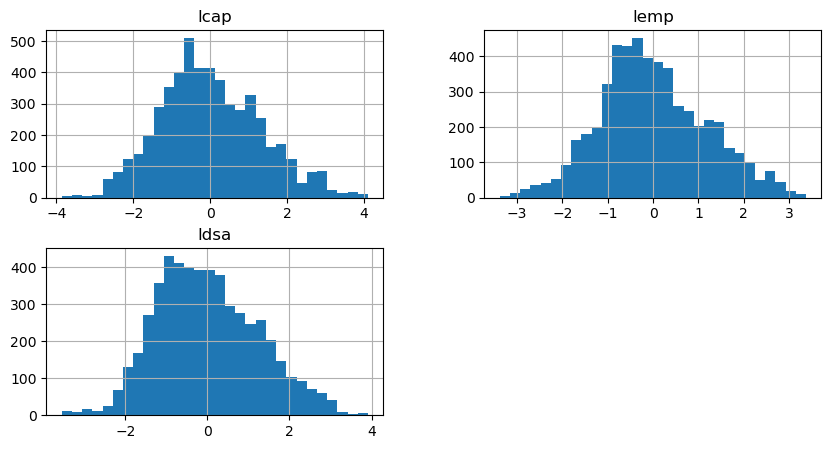

In [25]:
dat[['lcap','lemp','ldsa']].hist(bins=30, figsize=(10,5));
# ser ud til at være nogenlunde normalfordelte



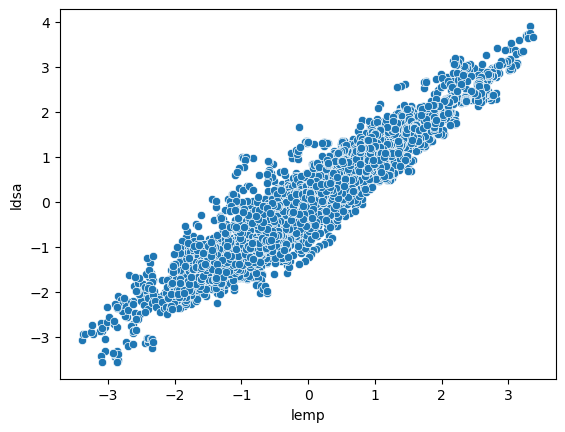

In [26]:
sns.scatterplot(x='lemp', y='ldsa', data=dat); 
# umiddelbart ser log ansatte ud til at være positivt korreleret med log omsætning

# Converting data to numpy format 

In [27]:
dat.ldsa.values.shape

(5292,)

In [28]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


Extract data from `pandas` to `numpy` arrays. 

In [29]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1)) # de laver et konstantled som repræsenterer det teknologiske niveau, A
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])
label_y = 'log_omsætning'
label_x = ['const', 'log_ansatte', 'log_kapital']
# sætter N = 441
N = 441
# sætter T = 12
T = 12
rename_dict = {'year': 'aar', 'ldsa':'log_omsætning', 'lemp': 'log_ansatte', 'lcap': 'log_kapital'}
dat = dat.rename(columns=rename_dict)


# tester strict exo

# OLS

In [ ]:
# estimerer pooled ols
pooled_result = est.estimate(y, X, T=T)
est.print_table((label_y, label_x), pooled_result, title='Pooled OLS regression', floatfmt='.4f')


Pooled OLS regression
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
const        0.0000  0.0050      0.0000
log_ansatte  0.6748  0.0102     66.4625
log_kapital  0.3100  0.0091     33.9237
R² = 0.914
σ² = 0.131


# FE

In [21]:
# renamer kolonner til lettere genkendeligt navne
N= 441
rename_dict = {'year': 'aar', 'ldsa':'log_omsætning', 'lemp': 'log_ansatte', 'lcap': 'log_kapital'}
dat = dat.rename(columns=rename_dict)

# transformerer data med en time-demeaning matrix
def demeaning_matrix(T):
    Q_T = np.eye(T) - (np.ones((T,T)))/T
    return Q_T
Q_T = demeaning_matrix(T)

# transformerer y og X
y_demean = y - np.repeat(np.mean(y.reshape(N, T), axis=1), T)
x_demean = X - np.repeat(np.mean(X.reshape(N, T, X.shape[1]), axis=1), T, axis=0)


# fjerner konstantleddet
x_demean = x_demean[:,1:]
# Estimate FE OLS using the demeaned variables.
# Demean using Q_T for each firm
# Reshape y and X to (N, T, ...) and apply Q_T along the time dimension
y_panel = y.reshape(N, T)
x_panel = X[:,1:].reshape(N, T, 2)  # remove constant before demeaning

y_demean = (Q_T @ y_panel.T).T.reshape(N*T, 1)
x_demean = np.empty((N*T, 2))
for j in range(2):
    x_demean[:,j] = (Q_T @ x_panel[:,:,j].T).T.reshape(N*T)

# Estimate FE OLS using the demeaned variables.
fe_result = est.estimate(y_demean, x_demean, 'fe', T=T)
# Print results
est.print_table((label_y, label_x[1:]), fe_result, title='FE regression', floatfmt='.4f')

FE regression
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
log_ansatte  0.6942  0.0147     47.2447
log_kapital  0.1546  0.0130     11.9311
R² = 0.477
σ² = 0.018


In [14]:
import scipy.stats as stats
import numpy.linalg as la
b_hat = fe_result['b_hat']
cov = fe_result['cov']

# tester constant returns to scale hypotese
# med CRS er f(aK, aL) = a f(K,L)
# siden vi arbejder med log transformerede variable svarer det til at teste flg:
# H0: beta_k + beta_l = 1
# H1: beta_k + beta_l != 1
# vi tester med en wald test
R = np.array([[1, 1]]) # restriktionsmatrix
r = np.array([[1]]) # restriktionsværdi

numerator = R @ b_hat - r
denominator = R @ cov @ R.T
wald = float(numerator.T @ la.inv(denominator) @ numerator)
p_value = 1 - stats.chi2.cdf(wald, df=R.shape[0])
# det virker usandsynligt højt

print(f'Wald test statistic: {wald:.4f}')
print(f'p-value: {p_value:.4f}')
# en wald test statistic på 135 og en p værdi på 0.0000 indikerer
# at vi kan forkaste H0 om constant returns to scale


Wald test statistic: 135.1899
p-value: 0.0000


C:\Users\annal\AppData\Local\Temp\ipykernel_1140\4290725127.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wald = float(numerator.T @ la.inv(denominator) @ numerator)


# FD